# Covid Sandbox

The analysis is split in two parts: preparation and analysis. We prepare the environment and get all the data from the different sources, and then we analyse it by producing two timeline graphs for number of cases and 14-day cumulative number of cases. Each graph is per 100k population to be able to compare countries together.

*Note*: The [ECDC advises](https://www.ecdc.europa.eu/en/cases-2019-ncov-eueea) users of such country comparisons to use all data with caution and awareness of their limitations, and here we do the same.

Choose the countries you want to feature in the graphs below:

In [82]:
countries = ['DE', 'GB', 'CH', 'MT', 'HR', 'CN', 'IT', 'ES']

## Preparation
We will import some libraries that we will need.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import date

### Get COVID-19 data
We pull the latest data from WHO and print the first few rows below.

In [84]:
covid = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', skipinitialspace=True)
covid['Date_reported'] = pd.to_datetime(covid['Date_reported'])
print(covid.shape)
covid.head()

(42025, 8)


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-24,AF,Afghanistan,EMRO,5,5,0,0
1,2020-02-25,AF,Afghanistan,EMRO,0,5,0,0
2,2020-02-26,AF,Afghanistan,EMRO,0,5,0,0
3,2020-02-27,AF,Afghanistan,EMRO,0,5,0,0
4,2020-02-28,AF,Afghanistan,EMRO,0,5,0,0


### Get population data
We get population data from the World Bank.

In [85]:
# Import some zip libraries
from io import BytesIO
from zipfile import ZipFile
import urllib.request

population_url = 'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv'
request = urllib.request.urlopen(population_url)
populations = None

# Extract the relevant CSV file out of the zip file
with ZipFile(BytesIO(request.read())) as zip_file:
    for contained_file in zip_file.namelist():
        if not contained_file.startswith('Metadata'):
            print(contained_file)
            populations = pd.read_csv(zip_file.open(contained_file), skiprows=4)

populations = populations.rename(columns={'Country Code': 'ISO3166-1-Alpha-3',
                                          '2019': 'Population'})
populations = populations.set_index('ISO3166-1-Alpha-3')
populations = populations[['Population']]

print(populations.shape)
populations.head()

API_SP.POP.TOTL_DS2_en_csv_v2_1345178.csv
(264, 1)


,Population
ISO3166-1-Alpha-3,
ABW,106314.0
AFG,38041754.0
AGO,31825295.0
ALB,2854191.0
AND,77142.0


### Get country code mappings
The COVID-19 data comes with 2-letter codes for countries and the population data comes with 3-letter codes, so we need a mapping.

In [86]:
# We do a try/catch since datahub.io is not reliable
try:
    country_codes = pd.read_csv('https://datahub.io/core/country-codes/r/country-codes.csv')
    print("datahub.io works")
except:
    print("datahub.io is down, trying https://gist.github.com/radcliff/f09c0f88344a7fcef373 ...")
    country_codes = pd.read_csv('https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv')
    country_codes = country_codes.rename(columns={'Alpha-2 code':'ISO3166-1-Alpha-2', 'Alpha-3 code':'ISO3166-1-Alpha-3'})
    print("gist.github.com works")

country_codes = country_codes.set_index('ISO3166-1-Alpha-2')
country_codes = country_codes[['ISO3166-1-Alpha-3']]

print(country_codes.shape)
country_codes.head()

datahub.io works
(250, 1)


,ISO3166-1-Alpha-3
ISO3166-1-Alpha-2,
TW,TWN
AF,AFG
AL,ALB
DZ,DZA
AS,ASM


### Merge
We merge all datasets together

In [87]:
covid = covid.merge(country_codes, left_on='Country_code', right_on='ISO3166-1-Alpha-2', how="inner")
print(covid.shape)

covid = covid.merge(populations, on='ISO3166-1-Alpha-3', how="inner")
covid = covid.set_index(['Country_code'])
covid['Country_code'] = covid.index

print(covid.shape)
covid.head()

(42249, 9)
(39261, 10)


,Date_reported,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,ISO3166-1-Alpha-3,Population,Country_code
Country_code,,,,,,,,,,
AF,2020-02-24,Afghanistan,EMRO,5,5,0,0,AFG,38041754.0,AF
AF,2020-02-25,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF
AF,2020-02-26,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF
AF,2020-02-27,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF
AF,2020-02-28,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF


In [88]:
covid.index

Index(['AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF',
       ...
       'ZW', 'ZW', 'ZW', 'ZW', 'ZW', 'ZW', 'ZW', 'ZW', 'ZW', 'ZW'],
      dtype='object', name='Country_code', length=39261)

## Analysis
In this section we start crunching the data to produce the graphs we want.

### New cases per capita
We use the measure of new cases per 100k population

In [89]:
multiplier_100k = 100000
covid['New_cases_per_100k'] = covid['New_cases'] / (covid['Population'] / multiplier_100k)

covid.head(100)

,Date_reported,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,ISO3166-1-Alpha-3,Population,Country_code,New_cases_per_100k
Country_code,,,,,,,,,,,
AF,2020-02-24,Afghanistan,EMRO,5,5,0,0,AFG,38041754.0,AF,0.013143
AF,2020-02-25,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF,0.000000
AF,2020-02-26,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF,0.000000
AF,2020-02-27,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF,0.000000
AF,2020-02-28,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,AF,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
AF,2020-05-29,Afghanistan,EMRO,643,13659,11,246,AFG,38041754.0,AF,1.690248
AF,2020-05-30,Afghanistan,EMRO,784,14443,2,248,AFG,38041754.0,AF,2.060893
AF,2020-05-31,Afghanistan,EMRO,651,15094,2,250,AFG,38041754.0,AF,1.711278


And here we prepare the graph.

In [90]:
def prep_graph_data(data, countries, plot_column):
    graph_data = pd.DataFrame(data=None, index=pd.Index(data=[],name='Date reported'))

    for country in countries:
        country_data = data.xs(country).set_index('Date_reported')
        country_name = country_data['Country'][0]
        print(country_name)
        country_data = country_data[[plot_column]]
        country_data = country_data.rename(columns={plot_column: country_name})
        graph_data = graph_data.join(country_data, how="outer")

    graph_data = graph_data[graph_data['Malta'].map(math.isnan) == False]
    return graph_data[graph_data >= 0]
    
new_cases_per_100k = prep_graph_data(covid, countries, 'New_cases_per_100k')
new_cases_per_100k

Germany
The United Kingdom
Switzerland
Malta
Croatia
China
Italy
Spain


,Germany,The United Kingdom,Switzerland,Malta,Croatia,China,Italy,Spain
Date_reported,,,,,,,,
2020-03-07,0.341622,0.076308,0.676398,0.198944,0.024585,0.007298,2.068083,0.240033
2020-03-08,0.196072,0.121195,0.723046,0.397889,0.024585,0.003291,2.474402,0.000000
2020-03-09,0.066159,0.089774,0.758032,0.000000,0.000000,0.003220,2.980228,0.000000
2020-03-10,0.285086,0.085285,1.481079,0.397889,0.000000,0.001431,1.620302,1.380723
2020-03-11,0.188854,0.221443,2.367393,0.198944,0.024585,0.002218,3.835987,1.270265
...,...,...,...,...,...,...,...,...
2020-09-12,1.960718,5.295177,6.157555,0.000000,4.671174,0.001431,2.680049,22.486669
2020-09-13,1.140344,5.232335,5.422847,16.711330,6.416718,0.001646,2.489328,21.477679
2020-09-14,1.115083,4.982464,5.516143,20.889162,4.056546,0.002075,2.414698,12.855594


<AxesSubplot:xlabel='Date_reported'>

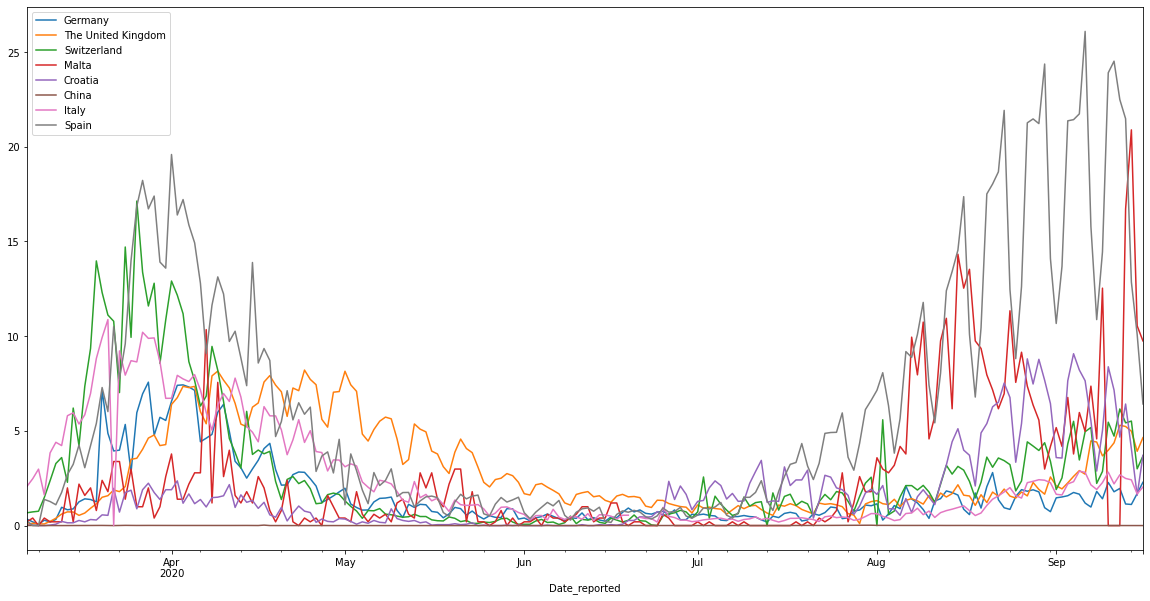

In [91]:
new_cases_per_100k.plot(figsize=(20,10))

### 14-day cumulative per capita
To smoothen the graph, and in line with some quarantine/travel restrictions of some countries including statistics shown by the ECDC, we take the sum of the last 14 days of new cases for the countries and then adjust per 100k population.

This takes a while to calculate, because each value has to be calculated over the sum of cases for the last 14 days, for each day since the beginning of the pandemic until now, and for each country. We try to optimise and we only take a few countries to be fast.

In [92]:
def prev14(country_data, from_date):
    daterange = pd.date_range(end=from_date, periods=14)
    return country_data[country_data['Date_reported'].isin(daterange)]
    
print(countries)

new_covid = pd.DataFrame(data=None, columns=covid.columns)
new_covid['14-day cumulative number of cases'] = []

for country in countries:
    print(country)
    country_data = covid.xs(country)
    country_data = country_data.set_index('Date_reported')
    country_data['Date_reported'] = country_data.index
    country_data['14-day cumulative number of cases'] = country_data.apply(lambda row:sum(prev14(country_data, row['Date_reported'])['New_cases']), axis=1)
    country_data = country_data.set_index('Country_code')
    new_covid = new_covid.append(country_data)

new_covid['14-day cumulative number of cases per 100k'] = new_covid['14-day cumulative number of cases'] / (new_covid['Population'] / multiplier_100k)
new_covid

['DE', 'GB', 'CH', 'MT', 'HR', 'CN', 'IT', 'ES']
DE
GB
CH
MT
HR
CN
IT
ES


,Date_reported,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,ISO3166-1-Alpha-3,Population,Country_code,New_cases_per_100k,14-day cumulative number of cases,14-day cumulative number of cases per 100k
DE,2020-01-28,Germany,EURO,1,1,0,0,DEU,83132799.0,NaN,0.001203,1.0,0.001203
DE,2020-01-29,Germany,EURO,3,4,0,0,DEU,83132799.0,NaN,0.003609,4.0,0.004812
DE,2020-01-30,Germany,EURO,0,4,0,0,DEU,83132799.0,NaN,0.000000,4.0,0.004812
DE,2020-01-31,Germany,EURO,1,5,0,0,DEU,83132799.0,NaN,0.001203,5.0,0.006014
DE,2020-02-01,Germany,EURO,2,7,0,0,DEU,83132799.0,NaN,0.002406,7.0,0.008420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ES,2020-09-12,Spain,EURO,10586,579233,45,29853,ESP,47076781.0,NaN,22.486669,124968.0,265.455703
ES,2020-09-13,Spain,EURO,10111,589344,46,29899,ESP,47076781.0,NaN,21.477679,123609.0,262.568930
ES,2020-09-14,Spain,EURO,6052,595396,55,29954,ESP,47076781.0,NaN,12.855594,123025.0,261.328403
ES,2020-09-15,Spain,EURO,4749,600145,31,29985,ESP,47076781.0,NaN,10.087776,122751.0,260.746375


And here the graph:

Germany
The United Kingdom
Switzerland
Malta
Croatia
China
Italy
Spain


<AxesSubplot:xlabel='Date_reported'>

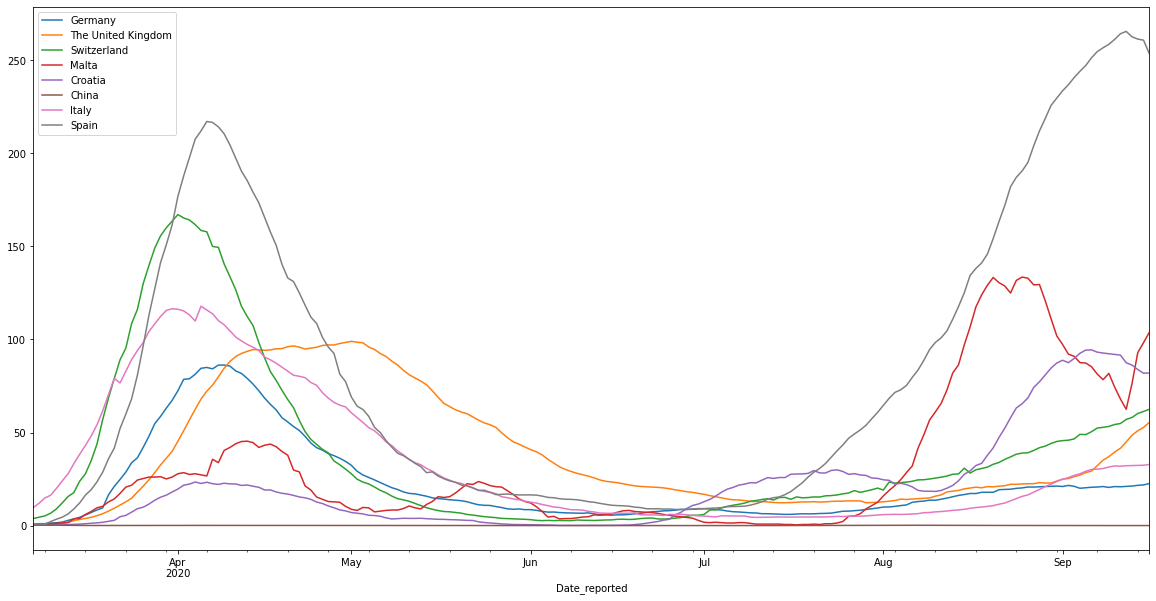

In [93]:
cum14data = prep_graph_data(new_covid, countries, '14-day cumulative number of cases per 100k')
cum14data.plot(figsize=(20,10))